In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"


zip_file = tf.keras.utils.get_file('flower_photos.tgz',
                                   origin=_URL,
                                   extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 3s 0us/step


In [4]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [5]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*.8)], images[round(len(images)*.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

print("Total training flowers: ", len(train))
print("Total validation flowers: ", len(val)) 


roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images
Total training flowers:  639
Total validation flowers:  160


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [7]:
batch_size =100
IMG_SHAPE = 150

In [8]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


In [9]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

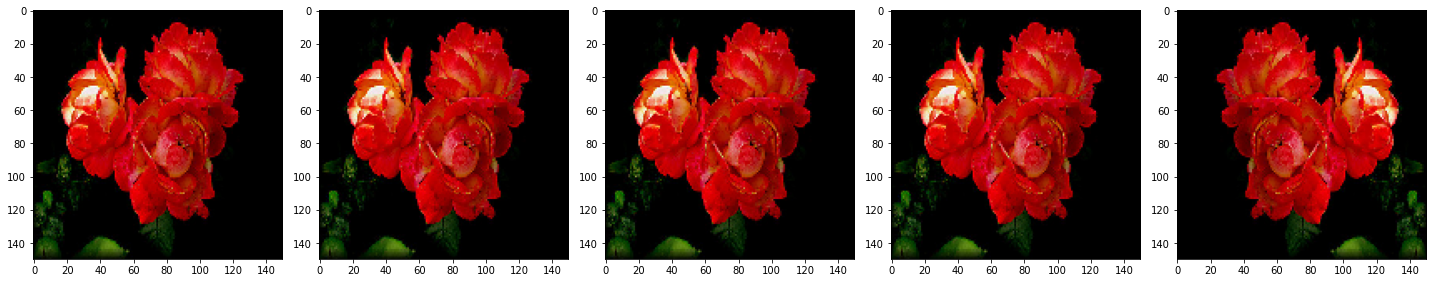

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


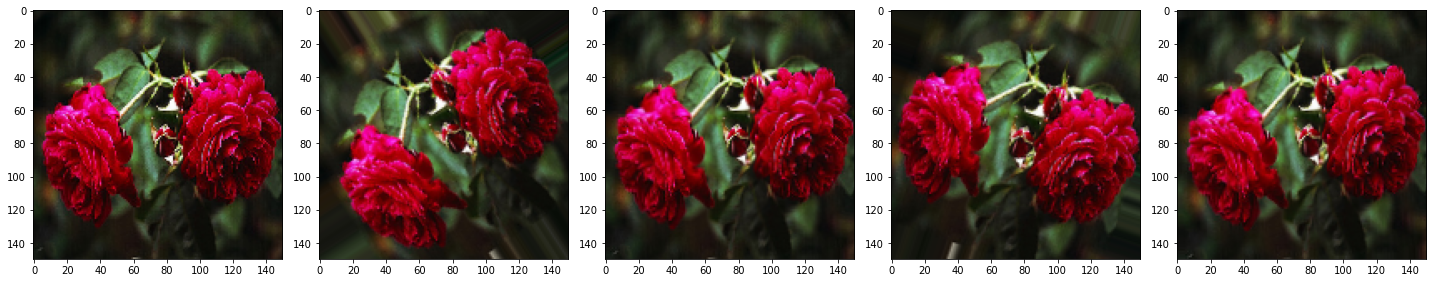

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


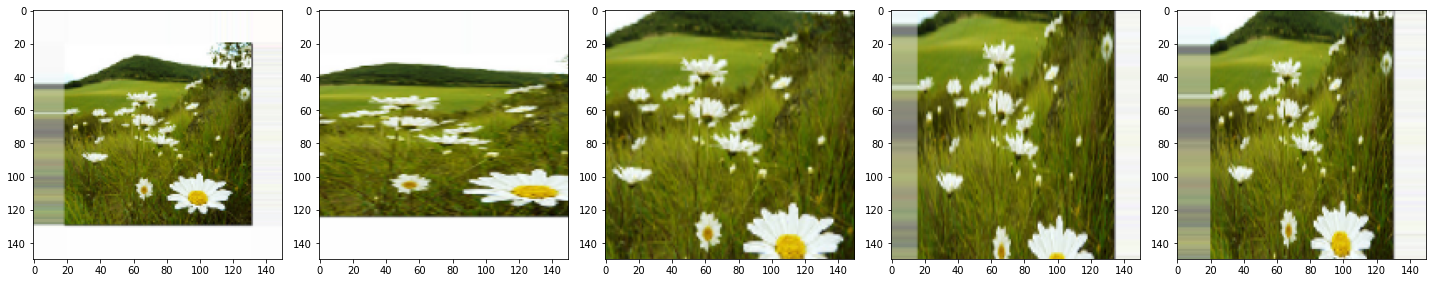

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [15]:
image_gen_train = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=45,
                                     zoom_range=0.5,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                     class_mode='sparse')

Found 2935 images belonging to 5 classes.


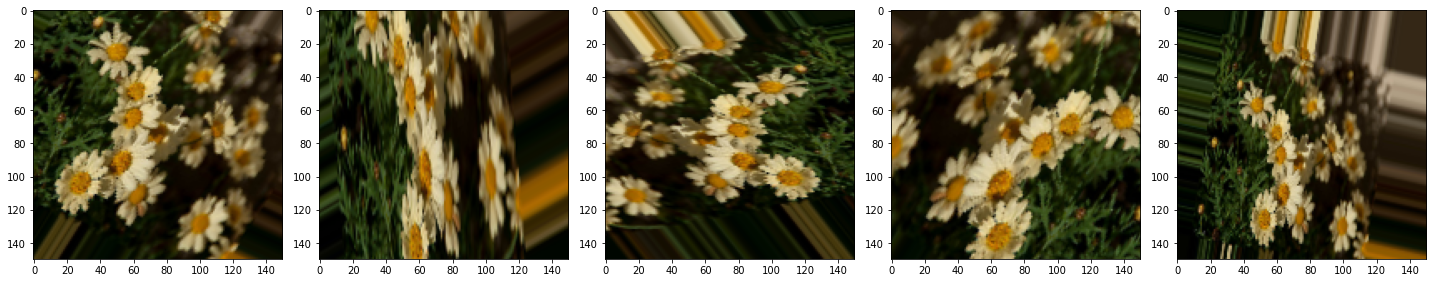

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [17]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                     directory=val_dir,
                                                     class_mode='sparse',
                                                     target_size=(IMG_SHAPE, IMG_SHAPE))

Found 735 images belonging to 5 classes.


In [18]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 80
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [21]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/80
30/30 [==============================] - 86s 3s/step - loss: 1.5794 - accuracy: 0.3434 - val_loss: 1.2689 - val_accuracy: 0.4585
Epoch 2/80
30/30 [==============================] - 85s 3s/step - loss: 1.2095 - accuracy: 0.4913 - val_loss: 1.0476 - val_accuracy: 0.6000
Epoch 3/80
30/30 [==============================] - 85s 3s/step - loss: 1.0910 - accuracy: 0.5564 - val_loss: 0.9625 - val_accuracy: 0.6245
Epoch 4/80
30/30 [==============================] - 85s 3s/step - loss: 1.0050 - accuracy: 0.5986 - val_loss: 0.8957 - val_accuracy: 0.6653
Epoch 5/80
30/30 [==============================] - 85s 3s/step - loss: 0.9693 - accuracy: 0.6194 - val_loss: 0.8556 - val_accuracy: 0.6721
Epoch 6/80
30/30 [==============================] - 85s 3s/step - loss: 0.9356 - accuracy: 0.6375 - val_loss: 0.8609 - val_accuracy: 0.6776
Epoch 7/80
30/30 [==============================] - 85s 3s/step - loss: 0.8907 - accuracy: 0.6463 - val_loss: 0.8109 - val_accuracy: 0.6898
Epoch 8/80
30/30 [==

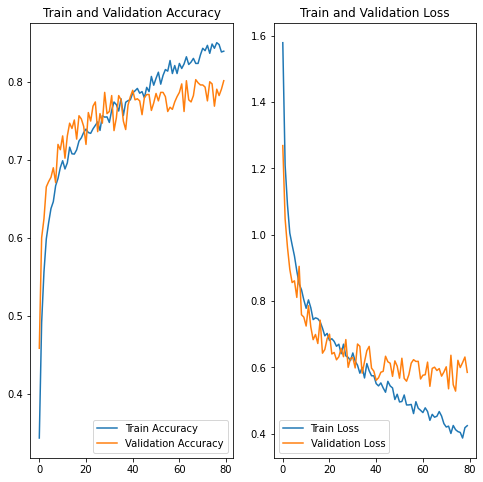

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Train and Validation Loss')

plt.show()